# Models (6)

*Anders Poirel - 23-06-2020*

In this notebook I will try to combine all the ideas that have worked well so far:
- merging features that represent the "same" thing (eg station and reanalysis temperatures) to get better estimates
- dropping correlated features
- using lagged features (up to 7 weeks to capture aspects of mosquito and dengue virus biology (incubation period, mosquito lifecycle)
- using previous predictions as model input features
- backfilling missing values instead of filling in with the median

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import (ElasticNet, Lasso, Ridge, LinearRegression)
from sklearn.model_selection import (cross_validate, TimeSeriesSplit)
from progestimator.prog_regression import ProgressiveRegression

In [72]:
mpl.rcParams['figure.dpi']= 150
sns.set()

## Reading the data

**Note**: this will require running `src/features/build_merged_lagged.py` to generate
the necessary data

In [239]:
RAW_PATH = '../data/raw'
PROCESSED_PATH = '../data/processed'

In [262]:
train_features = pd.read_csv(
    os.path.join(PROCESSED_PATH, 'merged_lag7_features_train.csv')
)
train_labels = pd.read_csv(
    os.path.join(RAW_PATH, 'dengue_labels_train.csv')
)
test_features = pd.read_csv(
    os.path.join(PROCESSED_PATH, 'merged_lag7_features_test.csv')
)

Seperate features and targets by city. We need to convert the targets to floats
for compatibility with `progestimator`

In [263]:
train_features_sj = train_features[
    train_features['city'] == 'sj'
].drop('city', axis = 1)
train_features_iq = train_features[
    train_features['city'] == 'iq'
].drop('city', axis = 1)

y_train_sj = train_labels[
    train_labels['city'] == 'sj'
]['total_cases'].astype('float')
y_train_iq = train_labels[
    train_labels['city'] == 'iq'
]['total_cases'].astype('float')

test_features_sj = test_features[
    test_features['city'] == 'sj'
].drop('city', axis = 1)
test_features_iq = test_features[
    test_features['city'] == 'iq'
].drop('city', axis = 1)

## Model

We want the ratio of data in each city to the full dataset to compute 
combined average CV scores

In [265]:
sj_ratio = len(train_features_sj) / len(train_features)
iq_ratio = len(train_features_iq) / len(train_features)

We need different pipelines for our date-related features and the other numerical
features

In [266]:
categorical_features = ['monthofyear']
numerical_features = list(train_features_sj.columns.values)
numerical_features.remove('monthofyear')
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])
numerical_transformer = Pipeline([
    ('scale', StandardScaler()),
#    ('poly', PolynomialFeatures(2))
])
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

### San Juan

In [271]:
plasso_1 = ProgressiveRegression(Lasso(1.2))
model_sj = Pipeline([
    ('pre', preprocessor),
    ('lasso', plasso_1)
])

In [272]:
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_features_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-32.25974800307058

#### Visualization

In [273]:
model_sj.fit(train_features_sj, y_train_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

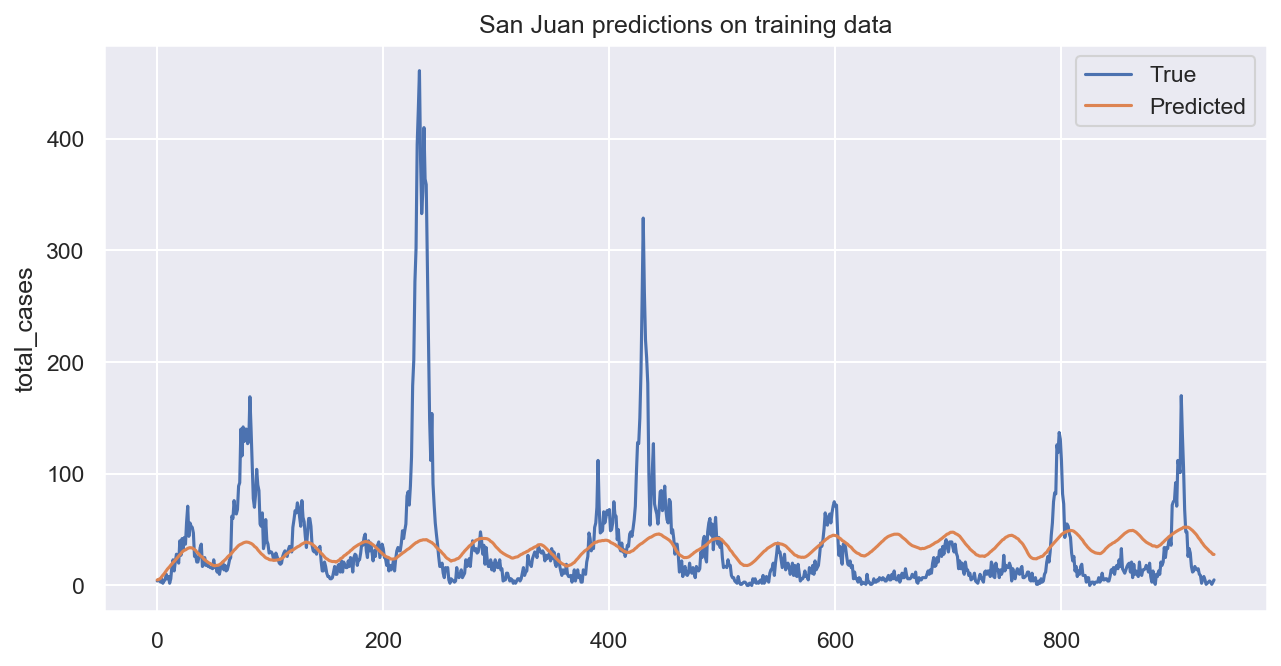

In [274]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

In [275]:
plasso_2 = ProgressiveRegression(Lasso(0.3))
model_iq = Pipeline([
    ('pre', preprocessor),
    ('lasso', plasso_2)
])

In [276]:
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_features_iq,
    y = y_train_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-6.395943527191657

#### Visualization

In [277]:
model_iq.fit(train_features_iq, y_train_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

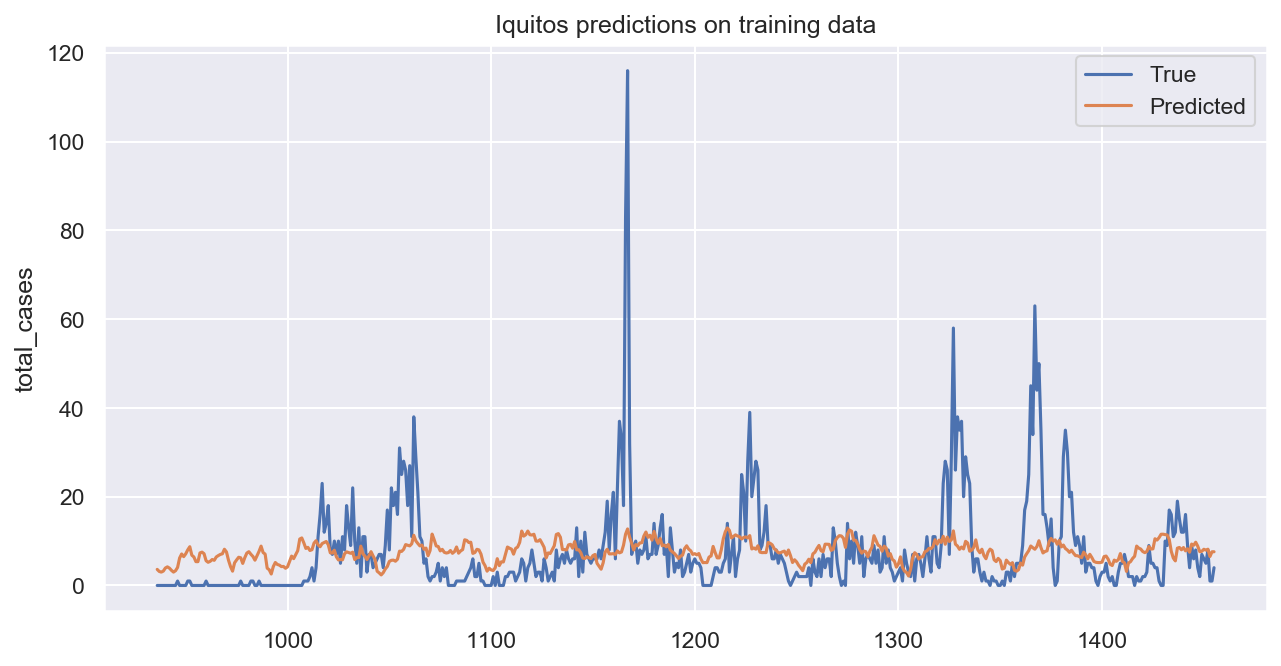

In [278]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Overall CV result

In [279]:
sj_ratio * sj_score + iq_ratio * iq_score

-23.02267497597096

This is similar to previous CV scores, which warrants a submission

### Model predictions

In [280]:
sub = pd.read_csv(
    os.path.join(RAW_PATH, 'submission_format.csv'))

In [281]:
y_pred_sj = model_sj.predict(test_features_sj)
y_pred_iq = model_iq.predict(test_features_iq)

In [282]:
y_pred = np.concatenate((y_pred_sj, y_pred_iq))
sub['total_cases'] = np.round(y_pred).astype(int)
sub.to_csv('../models/merged_lagged_prg.csv', index = None)

#### Model plots

San Juan

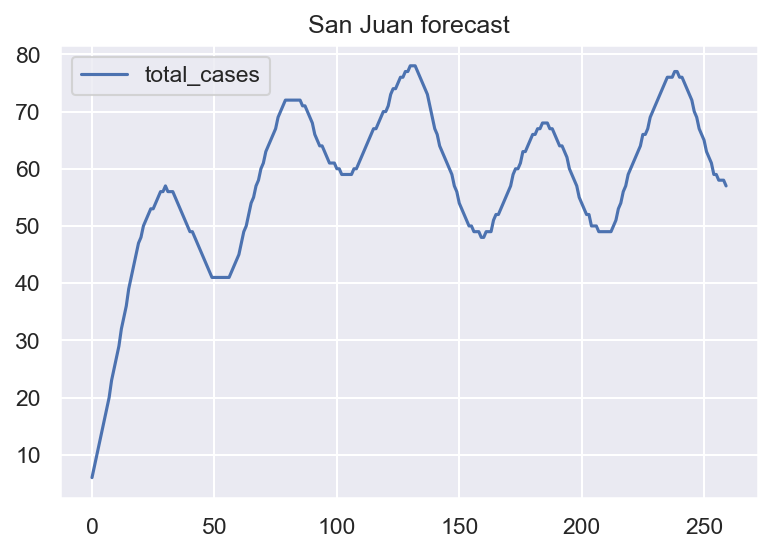

In [284]:
sub[sub['city'] == 'sj'].plot(
    y = 'total_cases', 
    title = 'San Juan forecast'
)

## Leaderboard results

27 MAE, it seems like the lagged features idea does not work